# A foreign function interface for UFL: `ExternalOperator`

This tutorial addresses (see corresponding paper: "[Escaping the abstraction: a foreign function interface for the Unified Form Language [UFL]](https://arxiv.org/abs/2111.00945)")

**Goal**: This notebook is a non exhaustive overview of the ExternalOperator interface. It aims to provide a concise and clear understanding of how ExternalOperator works (cf. I), and how one can design and implement his own operator using ExternalOperator (cf. II and III).

In addition, there are existing external operator subclasses implemented and accessible for different applications such as: neural networks, nonlocal boundary conditions, periodic orbits, multiscale optimization, implicit constitutive laws. Here are some notebooks associated to existing external operators:

- Deep learning based regularizer for seismic inversion:
- Neural networks using `ExternalOperator`: 
- PDEOperator: an operator representing the solution of a PDE: 

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from firedrake import *

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [3]:
mesh = UnitSquareMesh(50, 50)
V = FunctionSpace(mesh, "Lagrange", 1)

## 1 How does `ExternalOperator` work ?

If you just want to implement your own external operator without necessarily caring about how that works and what is happening behind the scenes, feel free to jump into the next section. (TODO: Add reference)

Requirements:
 - Define external operator mathematically (formally or informally) and introduce notion of linear forms
 - Explain $V^{\star}$
 - Quickly explain and illustrate differentiation
 - Explain Assembly of $N$
 - Parenthesis with picture for Jacobian without entering in much details
 - Explain very briefly that action adjoint translates into arguments. 2 things determine assembly (derivatives multi-index and arguments)
 - Picture table identifiers and math expression
 - Don't provide template but refer to next section where will se how to use those

### What is `ExternalOperator` ?

For more details, we refer the reader to [Escaping the abstraction: a foreign function interface for the Unified Form Language [UFL]](https://arxiv.org/abs/2111.00945)

Let $(V_i)_{1\le i\le l}$, $(W_i)_{1\le i\le k}$ and $X$ be finite element spaces. An external operator $N$ mapping $k$ operands to $X$ is defined as

\begin{equation}
\begin{aligned}
N :  W_1 \times \cdots \times W_k \times V_l \times \cdots \times V_{1} &\longmapsto  X \\
 u_1,\ \ldots,\ u_k,\ v_l,\ \ldots,\ v_1\  \quad &\longrightarrow N(u_1, \ldots, u_k; v_l, \ldots, v_1)
\end{aligned}
\end{equation}

Equivalently,

\begin{equation}
\begin{aligned}
N :  W_1 \times \cdots \times W_k \times  V_l \times \cdots V_1 \times X^{*} &\longmapsto \mathbb{R} \\
 u_1,\ \ldots,\ u_k,\ v_l,\ \ldots,\ v_1,\ v^{*} \quad &\longrightarrow N(u_1, \ldots, u_k; v_l, \ldots, v_1, v^{*})
\end{aligned}
\end{equation}


`ExternalOperator` is the UFL class representing external operators.

### Symbolic aspect

In [4]:
u = Function(V)
N = ExternalOperator(u, function_space=V)
print('\n u: %s\n N: %s' % (u, N))


 u: w₂
 N: e(w₂; v_0)


In [5]:
assert N.ufl_operands[0] == u

In [6]:
vstar, = N.argument_slots()
print(vstar)

v_0


In [7]:
from ufl.algorithms.ad import expand_derivatives

dNdu = derivative(N, u)
print('\n dNdu: %s' % (expand_derivatives(dNdu)))


 dNdu: ∂e(w₂; v_1, v_0)/∂o1


### Numerical aspect

`AbstractExternalOperator`

<figure>
  <center><img src="image/external_operators_DAG_residual.png" alt="rtcf_dg" style="width: 200px;"/></center>
  <center><figcaption>Add title
      </figcaption></center>
</figure>

\begin{equation}
\frac{d F(u, m, N(u,m; v^{*}); \hat{u}, v)}{d u} = \frac{\partial F(u, m, N; \hat{u}, v)}{\partial u} + \frac{\partial F(u, m, N; \widehat{N}, v)}{\partial N} \cdot \frac{\partial N(u, m; \hat{u}, v^{*})}{\partial u}
\end{equation}


In [8]:
v = TestFunction(V)
F = u * v * dx + N * v * dx
dFdu = derivative(F, u)
print('\n dFdu: %s' % (expand_derivatives(dFdu)))


 dFdu: { v_0 * v_1 } * dx(<Mesh #1>[everywhere], {})
  +  Action({ v_0 * v_1 } * dx(<Mesh #1>[everywhere], {}), ∂e(w₂; v_1, v_0)/∂o1)


<figure>
  <center><img src="image/external_operators_DAG_Jacobian.png" alt="DAG_J" style="width: 600px;"/></center>
  <center><figcaption> Add title
      </figcaption></center>
</figure>

**The assembly procedure can be understood as a depth-first traversal of a directed acyclic graph (DAG)!**

Now the assembly of the nodes $N$ and $\frac{\partial N}{\partial u}$ depends on the external operator considered.  and therefore need to be provided by the external operator subclass. For instance,

### Assembly identifiers

`AbtractExternalOperator` has an assembly mechanism that orchestrates the assembly of external operators by calling the corresponding implementation for each external operator term turning up in a form or an expression.

The key point is that the external operator assembly procedure is fully determined by the arguments and the derivative multi-index of the external operator. The derivative multi-index informs about the derivatives taken. On the other hand, the arguments of the external operator indicates whether action and/or adjoint has been applied.

Intially, each operator has one argument in the argument slots, i.e. $v^{*}$. Let $N$ be an `ExternalOperator` with $k$ arguments, it can be shown that the following property holds for any arbitrary linear $k$-forms, and in particular for $N$:

- Differentiating N increments its number of argument by 1. The resulting external operator is a (k+1)-form.
- Taking the action of $N$ on a appropriate $w$ equates to replace the highest-numbered argument of $N$ with $w$
- When $k=2$, taking the adjoint of $N$ is equivalent to swap both arguments

These properties enable to associate each external operator derived from $N$ to a unique identifier. The external operator assembly procedure is strictly determined by this identifier. **This assembly identifier is needed when one wants to build his own external operator since every evaluation implementation provided by a user needs to be decorated with that identifier.** Here are examples of external operator terms and the corresponding identifiers:

<figure>
  <center><img src="image/external_operators_assembly_identifiers.png" alt="rtcf_dg" style="width: 800px;"/></center>
  <center><figcaption>$RTCF_2$ (left) and $DQ_1 (right)$.
      Source: <a href="http://femtable.org/">periodic table of finite elements</a>
      </figcaption></center>
</figure>

<a id=’section_1’></a>
### Section 1

## Implement your own ExternalOperator

As mentioned in the b. In most cases, a new external operators needs to be designed a particular application of interest. The ExternalOperator interface provides an easy and powerful way

We present an expressive, flexible and powerful interface for incorporating arbitrary operators in UFL, and providing their implementation to Firedrake

If you are not familiar with the assembly identifier, you should have a look at section ...

Let's get started with a simple Poisson problem defined as:

For more details, see notebook: [Strong (Dirichlet) boundary conditions](./02-poisson.ipynb).

In [9]:
mesh = UnitSquareMesh(50, 50)
V = FunctionSpace(mesh, "Lagrange", 1)
x, y = SpatialCoordinate(mesh)
u_exact = Function(V).interpolate(sin(pi*x)*sin(pi*y))
f = Function(V).interpolate((1 + 2*pi**2)*u_exact)
u = Function(V)
v = TestFunction(V)
F = (inner(grad(u), grad(v)) + inner(u, v) - inner(f, v)) * dx
bcs = DirichletBC(V, 0, 'on_boundary')
solve(F == 0, u, bcs=bcs)

In [10]:
# Store solution obtained
u_solve = Function(V).assign(u)

For more details, see [Section 1](#section_1).

<IPython.core.display.Javascript object>


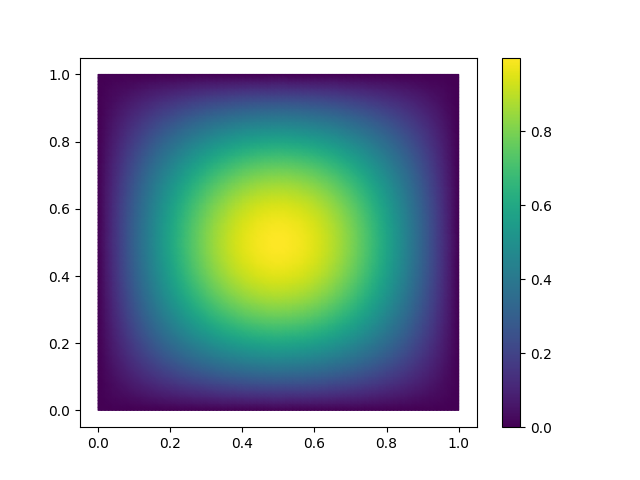

In [11]:
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots()
collection = tripcolor(u, axes=axes)
fig.colorbar(collection);

### A toy example: Translation operator

In this section, we will build our own external operator. For sake of simplicity, let's consider the following translation operator:

$$N(u, f; v^{\star}) =  u - f$$

In [12]:
class TranslationOperator(AbstractExternalOperator):

    def __init__(self, *operands, function_space, **kwargs):
        AbstractExternalOperator.__init__(self, *operands, function_space=function_space, **kwargs)

    @assemble_method(0, (0,))
    def assemble_N(self, *args, **kwargs):
        u, f = self.ufl_operands
        N = assemble(u - f)
        return N

N = TranslationOperator(u, f, function_space=V)

In [13]:
assembled_N = assemble(N)
assert np.allclose(assembled_N.dat.data_ro, u.dat.data_ro[:] - f.dat.data_ro[:])

In [14]:
# Important keep form assembly since shows that for evaluating F here just needs eval for N
F2 = (inner(grad(u), grad(v)) + inner(N, v)) * dx
assembled_F2 = assemble(F2)

In [15]:
assembled_F = assemble(F)
assert np.allclose(assembled_F.dat.data_ro, assembled_F2.dat.data_ro)

Now let's go back to our problem, we want to solve:

In order to solve the above equation, we need to differentiate the residual form $F$ to obtain the Jacobian of $F$. Consequently, it follows from chain rule that we need to be able to differentiate $N$ with respect to $u$ and compute its Jacobian. The differentiation is handled by UFL, but the computation of the Jacobian of $N$ depends on the external operator considered. It is therefore the responsability of the external operator subclass to provide an implementation for calculating the Jacobian.

In our case, the Gâteaux derivatives of $N$ are defined as:


\begin{equation}
\begin{aligned}
\frac{\partial N(u, f; \hat{u}, v^{\star})}{\partial u} &= \hat{u}  \quad \forall \hat{u} \in V\\
\frac{\partial N(u, f; \hat{f}, v^{\star})}{\partial f} &= -\hat{f} \quad \forall \hat{f} \in V
\end{aligned}
\end{equation}

In [16]:
class TranslationOperator(AbstractExternalOperator):

    def __init__(self, *operands, function_space, **kwargs):
        AbstractExternalOperator.__init__(self, *operands, function_space=function_space, **kwargs)

    @assemble_method(0, (0,))
    def assemble_N(self, *args, **kwargs):
        u, f = self.ufl_operands
        N = assemble(u - f)
        return N

    @assemble_method((1, 0), (0, 1))
    def assemble_Jacobian(self, *args, **kwargs):
        dNdu = Function(self.function_space()).assign(1)

        # Construct the Jacobian matrix
        integral_types = set(['cell'])
        assembly_opts = kwargs.get('assembly_opts')
        J = self._matrix_builder((), assembly_opts, integral_types)
        with dNdu.dat.vec as vec:
            J.petscmat.setDiagonal(vec)
        return J

Note that we specify the assembly method for $\frac{\partial N}{\partial u}$ (via `@assemble_method((1, 0), (0, 1))`) but we didn't specify how to compute the derivative with respect to $f$: $\frac{\partial N}{\partial f}$. This is simply because in order to solve the PDE, differentiating with respect to $F$ is not necessary. Therefore, if one provides the assembly implementation for $\frac{\partial N}{\partial f}$, that implementation will never be called. However in our external operator is to be used in a context where that derivative is required, we would need to add an implementation for the derivative of $N$ with respect to $f$ (via `@assemble_method((0, 1), (0, 1))`).

In [19]:
u = Function(V)
N = TranslationOperator(u, f, function_space=V)
F = (inner(grad(u), grad(v)) + inner(N, v)) * dx
solve(F == 0, u, bcs=bcs)

<IPython.core.display.Javascript object>


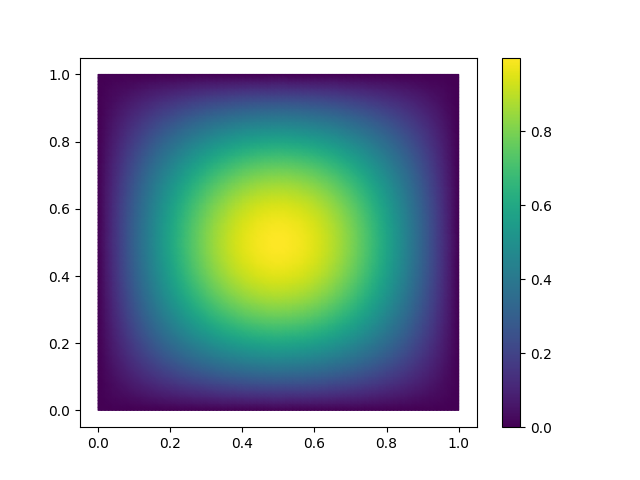

In [20]:
# NBVAL_IGNORE_OUTPUT
fig, axes = plt.subplots()
collection = tripcolor(u, axes=axes)
fig.colorbar(collection);

We can compare the solution obtained for the Poisson problem with and without external operators and confirm that they identical.

In [21]:
assert assemble((u - u_solve)**2 * dx) < 1e-12

### Matrix-free

In many cases, computing the Jacobian of the residual form is not appropriate, or even not possible. Instead, one may want to use matrix-free methods for solve the PDE problem of interest. In that case, the Jacobian of $F$ won't be assembled. Instead, only the action of the Jacobian will be used. As a consequence, our external operator subclass will need to be equipped with an implementation stating how the action of the Jacobian of $N$ can be assembled, i.e. how to compute the Jacobian-vector product of $N$.

In [22]:
class TranslationOperator(AbstractExternalOperator):

    def __init__(self, *operands, function_space, **kwargs):
        AbstractExternalOperator.__init__(self, *operands, function_space=function_space, **kwargs)

    @assemble_method(0, (0,))
    def assemble_N(self, *args, **kwargs):
        u, f = self.ufl_operands
        N = assemble(u - f)
        return N

    @assemble_method((1, 0), (0, None))
    def assemble_Jacobian_action(self, *args, **kwargs):
        w = self.argument_slots()[-1]
        return w

Cite use petsc options and refer to corresponding website firedrake that explains this.

In [23]:
u = Function(V)
N = TranslationOperator(u, f, function_space=V)
F = (inner(grad(u), grad(v)) + inner(N, v)) * dx

solve(F == 0, u, bcs=bcs, solver_parameters={"mat_type": "matfree",
                                             "ksp_type": "cg",
                                             "pc_type": "none"})

In [24]:
assert assemble((u - u_solve)**2 * dx) < 1e-12

## Adjoint and PDE-constrained optimisation

Requirements:
 - Briefly mention inverse problem
 - Illustrate Tikhonov regularisation
 - Why do we need adjoint ? Mention briefly adjoint equation
 - Add new Tikhonov regularization class: Use translation operator and enrich it with adjoint.


\begin{equation}
\min_{f \in V}\ \ \frac{1}{2}\|{u(f) - u^{obs}}\|_{L2}^{2} + \frac{1}{2}\|\mathcal{R}\left(f, f_{0}\right)\|_{L2}^{2}
\end{equation}

subject to

\begin{equation}
\label{regularizer_wave_Example}
\begin{aligned}
  - \Delta u + u &= f &\textrm{in}\ \Omega\\
 	u &= 0  &\textrm{on}\ \partial \Omega\\
\end{aligned}
\end{equation}


where $\mathcal{R}$ is a regularizer. In our case, we consider a general Tikhonov regularization, that is:

$$\mathcal{R}(f, f_{0}) = f - f_{0}$$

In order to illustrate the use of external operator in a PDE-constrained optimization problem, we consider an external operator representing the Tikhonov regularizer $\mathcal{R}$. Note that the external operator needed here is exactly the same that the `TranslationOperator` that we have built in the previous section. The only difference lies in the operands of the operator. It is worth noting that there is no restriction in the number of external operators one can use, or whether they are being used in the PDE-constraint or the cost function.

In [25]:
from firedrake_adjoint import *

In [26]:
f_exact = Function(V).interpolate((1 + 2*pi**2)*u_exact)
# Set observed data
u_obs = Function(V).assign(u_exact)
# Add noise
scale_noise = 5e-2
noise = scale_noise * np.random.rand(V.node_count)
u_obs.dat.data[:] += noise

alpha = 1e-3

In [27]:
f_0 = Function(V).assign(1)

/home/nacime/firedrake/src/firedrake/firedrake/adjoint/function.py:111: UserWarning: Could not find overloaded class of type '<class 'int'>'.
  other = create_overloaded_object(other)


<IPython.core.display.Javascript object>


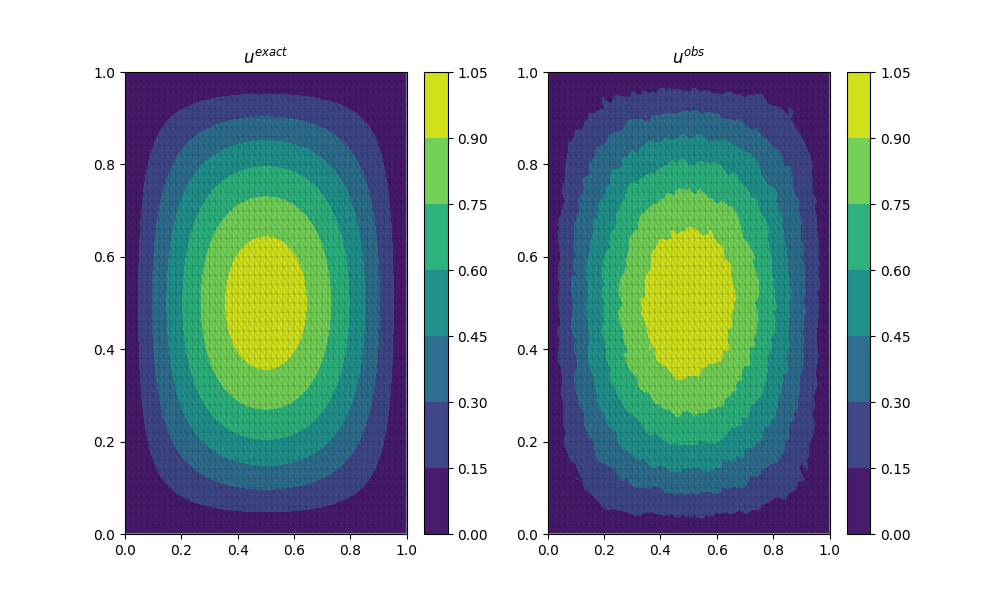

Text(0.5, 1.0, '$u^{obs}$')

In [28]:
plt.figure(figsize=(10,6))
plt.subplot(121)
ax = plt.gca()
l = tricontourf(u_exact, axes=ax)
triplot(mesh, axes=ax, interior_kw=dict(alpha=0.05))
plt.colorbar(l)
plt.title("$u^{exact}$")

plt.subplot(122)
ax = plt.gca()
l = tricontourf(u_obs, axes=ax)
triplot(mesh, axes=ax, interior_kw=dict(alpha=0.05))
plt.colorbar(l)
plt.title(r"$u^{obs}$")


Given an objective functional $J:V\rightarrow\mathbb R$, the adjoint equation is given by

$$\frac{\partial F}{\partial u}^{\ast}\lambda=\frac{\partial J}{\partial u}^{\ast},\quad\lambda\in V.$$

In [29]:
class TranslationOperator(AbstractExternalOperator):

    def __init__(self, *operands, function_space, **kwargs):
        AbstractExternalOperator.__init__(self, *operands, function_space=function_space, **kwargs)

    @assemble_method(0, (0,))
    def assemble_N(self, *args, **kwargs):
        f, f0 = self.ufl_operands
        N = assemble(u - f)
        return N

    @assemble_method((1, 0), (0, None))
    def assemble_Jacobian_action(self, *args, **kwargs):
        x = self.argument_slots()[-1]
        return x

    @assemble_method((1, 0), (None, 0))
    def assemble_Jacobian_adjoint_action(self, *args, **kwargs):
        y = self.argument_slots()[0]
        import ipdb; ipdb.set_trace()
        return y


In [30]:
tikhonov_operator = partial(TranslationOperator, function_space=V)

In [31]:
def J(f):
    R = tikhonov_operator(f, f_0)
    F = (inner(grad(u), grad(v)) + inner(u, v) - inner(f, v)) * dx
    solve(F == 0, u, bcs=bcs)
    return assemble(0.5 * (u - u_obs) ** 2 * dx + 0.5 * alpha * R**2 * dx)

c = Control(f)
Jhat = ReducedFunctional(J(f), c)

In [32]:
f_opt = minimize(Jhat)

> /tmp/ipykernel_8444/102472560.py(21)assemble_Jacobian_adjoint_action()
     19         y = self.argument_slots()[0]
     20         import ipdb; ipdb.set_trace()
---> 21         return y

ipdb> c


<IPython.core.display.Javascript object>


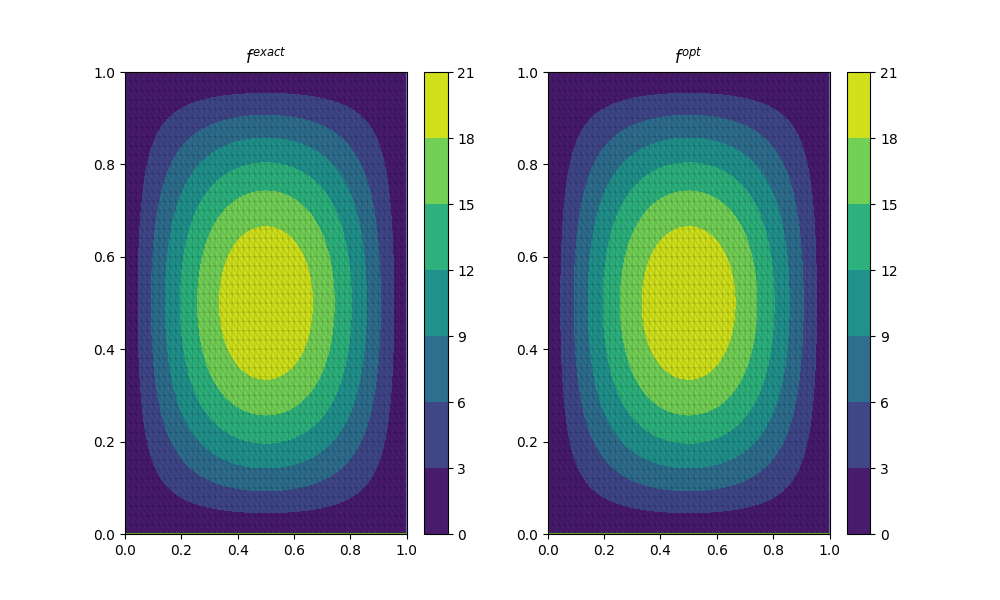

Text(0.5, 1.0, '$f^{opt}$')

In [33]:
plt.figure(figsize=(10,6))
plt.subplot(121)
ax = plt.gca()
l = tricontourf(f_exact, axes=ax)
triplot(mesh, axes=ax, interior_kw=dict(alpha=0.05))
plt.colorbar(l)
plt.title("$f^{exact}$")

plt.subplot(122)
ax = plt.gca()
l = tricontourf(f_opt, axes=ax)
triplot(mesh, axes=ax, interior_kw=dict(alpha=0.05))
plt.colorbar(l)
plt.title(r"$f^{opt}$")

In [34]:
assemble((f_exact - f_opt)**2 * dx) / assemble(f_exact**2 * dx)

1.0993631343915214e-33